In [1]:
import os
import cv2
import sys
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn 
import torch.optim as optim
from PIL import  Image
import numpy as np 
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp

sys.path.append(os.path.abspath("../utils"))  #
from dataset import  CustomDataset
from loader import create_data_loaders
from metrics import calculate_metrics
from early_stopping import EarlyStopping
from visual import visualization
import time 

/Users/zekariamohamed/anaconda3/envs/yolov10/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Both image and mask folders exists
Image size: (512, 512), Width: 512, Height: 512


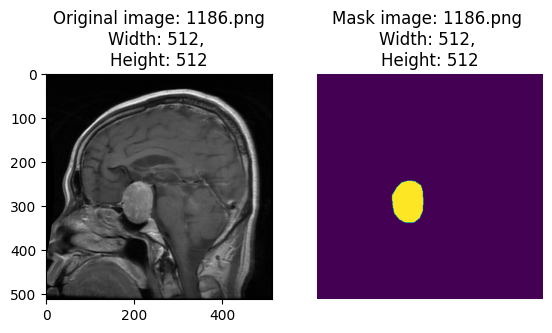

In [2]:
image_folder_path = "../Data/images" 
mask_folder_path = "../Data/masks"

image_paths = sorted([os.path.join(image_folder_path, img) for img in os.listdir(image_folder_path)])
mask_paths = sorted([os.path.join(mask_folder_path, mask) for mask in os.listdir(mask_folder_path)])

if os.path.exists(image_folder_path) and os.path.exists(mask_folder_path):
    print("Both image and mask folders exists")
else:
    print("One of the folders does not exist")
    exit()


def get_image_size(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    if image is None:
        print("Image not found")
    else: 
        height, width = image.shape[:2]
        return height, width


#* image files 

image_files = os.listdir(image_folder_path)

if len(image_files)> 0:
    
    image_file = image_files[3]
    
    image_path = os.path.join(image_folder_path, image_file)
    mask_file = image_file
    mask_path = os.path.join(mask_folder_path, mask_file)
    
    image_size = get_image_size(image_path)
    
    if image_size is not None:
        print(f"Image size: {image_size}, Width: {image_size[0]}, Height: {image_size[1]}")
        
        #* loading the images and plot it 
        
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f"Original image: {image_file}\nWidth: {image_size[0]}, \nHeight: {image_size[1]}")
        
        #* loading the mask and plot it 
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap="viridis")
        plt.title(f"Mask image: {mask_file} \nWidth: {image_size[0]}, \nHeight: {image_size[1]}")
        plt.axis('off')
        plt.show()
    else:
        print("Error reading images size") 
else:
    print("No images found in the folder")
    exit()  

In [3]:
#* splitting the dataset into train, val and test
val_ratio = 1 / 9
train_image_paths, test_image_paths, train_mask_paths, test_mask_paths = train_test_split(image_paths, mask_paths, test_size=0.1, random_state=42)
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(train_image_paths, train_mask_paths, test_size=val_ratio, random_state=42)

train_loader, val_loader, test_loader = create_data_loaders(train_image_paths, train_mask_paths, val_image_paths, val_mask_paths, test_image_paths, test_mask_paths, batch_size=32)

#* checking the data loaders 
print(f"training dataset: {len(train_loader.dataset)}")
print(f"validation dataset: {len(val_loader.dataset)}")
print(f"test dataset: {len(test_loader.dataset)}")

training dataset: 2450
validation dataset: 307
test dataset: 307


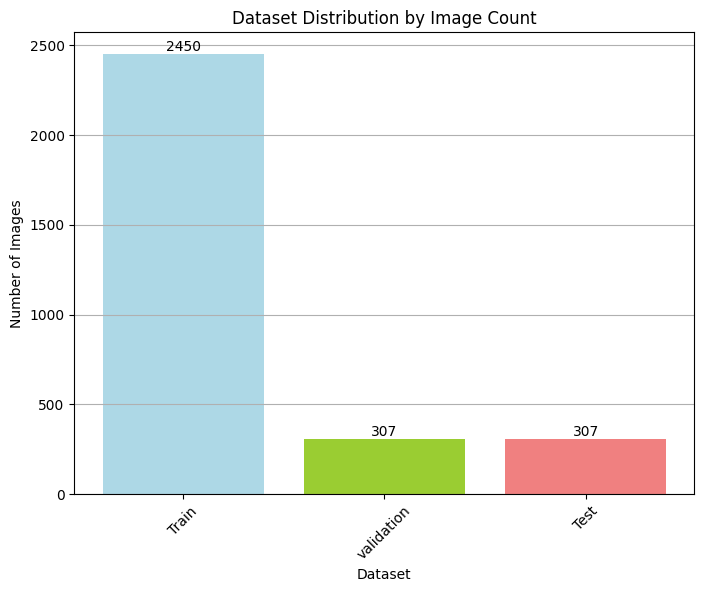

In [4]:
train_dataset_size = len(train_loader.dataset)
val_dataset_size = len(val_loader.dataset)
test_dataset_size = len(test_loader.dataset)

size = [train_dataset_size, val_dataset_size, test_dataset_size]
labels = ['Train', 'validation', 'Test']
colors = ['lightblue', 'yellowgreen', 'lightcoral']
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, size, color =colors)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')
plt.title("Dataset Distribution by Image Count")
plt.xlabel("Dataset")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()
 

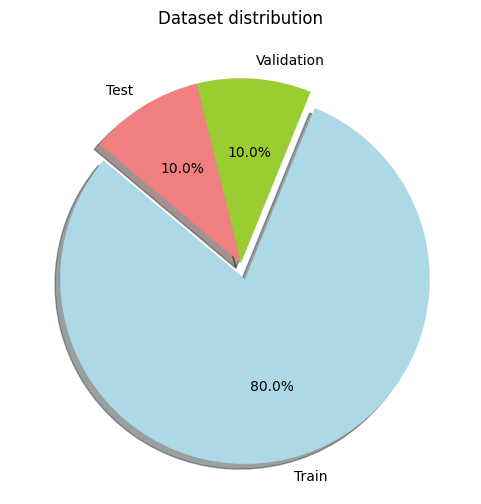

In [5]:
#* Dataset distribution
train_set_size = len(train_loader.dataset)
val_set_size = len(val_loader.dataset)
test_set_size =len(test_loader.dataset)

sizes = [train_set_size, val_set_size, test_set_size]
labels = ['Train', 'Validation', 'Test']
colors = ['lightblue', 'yellowgreen', 'lightcoral']
explode = (0.09, 0, 0)

plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.gca().set_aspect('equal') 
plt.title("Dataset distribution")   
plt.show()


In [6]:
#* training the model 
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using Device: {device}")

encoder_name = "resnet50"
encoder_weights = "imagenet"
in_channels = 3
classes = 1 

model = smp.Unet(
    
    encoder_name = encoder_name,
    encoder_weights = encoder_weights, 
    in_channels = in_channels,
    classes = classes
)


model.to(device)

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        
    def forward(self, y_pred, y_true):
        # Apply sigmoid manually instead of logsigmoid().exp()
        y_pred = torch.sigmoid(y_pred)
        
        # Flatten
        y_pred = y_pred.view(-1)
        y_true = y_true.view(-1)
        
        # Calculate Dice
        intersection = (y_pred * y_true).sum()
        dice = (2. * intersection + self.smooth) / (y_pred.sum() + y_true.sum() + self.smooth)
        
        return 1 - dice

#criterion = nn.BCEWithLogitsLoss() #* Binary cross Entropy 
criterion = DiceLoss() #* Dice loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30


Using Device: mps


In [7]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, early_stopping=None):
    train_loss_values = []
    val_loss_values = []
    train_acc_values = []
    val_acc_values = []
    dice_values = []
    iou_values = []

    best_model_state = None
    best_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_acc = 0.0

        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Training pixel accuracy
            acc, _, _, _, _, _ = calculate_metrics(outputs, masks)
            running_acc += acc

        avg_train_loss = running_loss / len(train_loader)
        avg_train_acc = running_acc / len(train_loader)

        train_loss_values.append(avg_train_loss)
        train_acc_values.append(avg_train_acc)

        # Validation
        model.eval()
        val_running_loss = 0.0
        val_running_acc = 0.0
        val_dice_total = 0.0
        val_iou_total = 0.0

        with torch.no_grad():
            for val_images, val_masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                val_images = val_images.to(device)
                val_masks = val_masks.to(device)

                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_masks)
                val_running_loss += val_loss.item()

                acc, _, _, _, iou, dice = calculate_metrics(val_outputs, val_masks)
                val_running_acc += acc
                val_dice_total += dice
                val_iou_total += iou

        avg_val_loss = val_running_loss / len(val_loader)
        avg_val_acc = val_running_acc / len(val_loader)
        avg_dice = val_dice_total / len(val_loader)
        avg_iou = val_iou_total / len(val_loader)

        val_loss_values.append(avg_val_loss)
        val_acc_values.append(avg_val_acc)
        dice_values.append(avg_dice)
        iou_values.append(avg_iou)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f} | "
              f"Train Acc: {avg_train_acc:.4f}, Val Acc: {avg_val_acc:.4f} | Dice: {avg_dice:.4f}, IoU: {avg_iou:.4f}")

        if early_stopping is not None:
            early_stopping(avg_val_loss)
            if early_stopping.stop_training:
                print("Early stopping triggered!")
                break

        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
            print(f"New best model saved! Validation loss: {best_loss:.4f}")

    return (train_loss_values, val_loss_values,
            train_acc_values, val_acc_values,
            dice_values, iou_values,
            best_model_state)

In [8]:
def save_best_model(model_state, filename):
    torch.save(model_state, filename)

In [9]:
earlyStopping = EarlyStopping(patience=5, mode='min')
training_losses, val_losses, train_accs, val_accs, dice_values, iou_values, best_model_state = train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, earlyStopping)

if best_model_state is not None:
    save_best_model(best_model_state, "best_model_U-Net.pth")


Epoch 1/30 - Validation: 100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


Epoch 1/30 | Train Loss: 0.7139, Val Loss: 0.5128 | Train Acc: 0.9426, Val Acc: 0.9782 | Dice: 0.5075, IoU: 0.3414
New best model saved! Validation loss: 0.5128


Epoch 2/30 - Validation: 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


Epoch 2/30 | Train Loss: 0.3871, Val Loss: 0.4290 | Train Acc: 0.9877, Val Acc: 0.9826 | Dice: 0.5770, IoU: 0.4074
New best model saved! Validation loss: 0.4290


Epoch 3/30 - Validation: 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


Epoch 3/30 | Train Loss: 0.3404, Val Loss: 0.3234 | Train Acc: 0.9891, Val Acc: 0.9906 | Dice: 0.6776, IoU: 0.5159
New best model saved! Validation loss: 0.3234


Epoch 4/30 - Validation: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


Epoch 4/30 | Train Loss: 0.3221, Val Loss: 0.3740 | Train Acc: 0.9897, Val Acc: 0.9882 | Dice: 0.6282, IoU: 0.4600


Epoch 5/30 - Validation: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


Epoch 5/30 | Train Loss: 0.3064, Val Loss: 0.3148 | Train Acc: 0.9901, Val Acc: 0.9898 | Dice: 0.6863, IoU: 0.5246
New best model saved! Validation loss: 0.3148


Epoch 6/30 - Validation: 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


Epoch 6/30 | Train Loss: 0.2932, Val Loss: 0.3021 | Train Acc: 0.9907, Val Acc: 0.9893 | Dice: 0.7008, IoU: 0.5406
New best model saved! Validation loss: 0.3021


Epoch 7/30 - Validation: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


Epoch 7/30 | Train Loss: 0.2615, Val Loss: 0.2676 | Train Acc: 0.9915, Val Acc: 0.9915 | Dice: 0.7331, IoU: 0.5818
New best model saved! Validation loss: 0.2676


Epoch 8/30 - Validation: 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


Epoch 8/30 | Train Loss: 0.2476, Val Loss: 0.2669 | Train Acc: 0.9920, Val Acc: 0.9917 | Dice: 0.7333, IoU: 0.5808
New best model saved! Validation loss: 0.2669


Epoch 9/30 - Validation: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


Epoch 9/30 | Train Loss: 0.2555, Val Loss: 0.2622 | Train Acc: 0.9917, Val Acc: 0.9907 | Dice: 0.7396, IoU: 0.5888
New best model saved! Validation loss: 0.2622


Epoch 10/30 - Validation: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


Epoch 10/30 | Train Loss: 0.2499, Val Loss: 0.2738 | Train Acc: 0.9918, Val Acc: 0.9900 | Dice: 0.7280, IoU: 0.5741


Epoch 11/30 - Validation: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


Epoch 11/30 | Train Loss: 0.2543, Val Loss: 0.2676 | Train Acc: 0.9917, Val Acc: 0.9906 | Dice: 0.7341, IoU: 0.5813


Epoch 12/30 - Validation: 100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


Epoch 12/30 | Train Loss: 0.2431, Val Loss: 0.3070 | Train Acc: 0.9921, Val Acc: 0.9878 | Dice: 0.6957, IoU: 0.5352


Epoch 13/30 - Validation: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Epoch 13/30 | Train Loss: 0.2349, Val Loss: 0.2821 | Train Acc: 0.9923, Val Acc: 0.9913 | Dice: 0.7186, IoU: 0.5644


Epoch 14/30 - Validation: 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


Epoch 14/30 | Train Loss: 0.2451, Val Loss: 0.2527 | Train Acc: 0.9920, Val Acc: 0.9923 | Dice: 0.7466, IoU: 0.6011
New best model saved! Validation loss: 0.2527


Epoch 15/30 - Validation: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


Epoch 15/30 | Train Loss: 0.2447, Val Loss: 0.2519 | Train Acc: 0.9920, Val Acc: 0.9923 | Dice: 0.7479, IoU: 0.6007
New best model saved! Validation loss: 0.2519


Epoch 16/30 - Validation: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


Epoch 16/30 | Train Loss: 0.2281, Val Loss: 0.2487 | Train Acc: 0.9927, Val Acc: 0.9914 | Dice: 0.7521, IoU: 0.6047
New best model saved! Validation loss: 0.2487


Epoch 17/30 - Validation: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


Epoch 17/30 | Train Loss: 0.2186, Val Loss: 0.2450 | Train Acc: 0.9929, Val Acc: 0.9914 | Dice: 0.7559, IoU: 0.6102
New best model saved! Validation loss: 0.2450


Epoch 18/30 - Validation: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


Epoch 18/30 | Train Loss: 0.2254, Val Loss: 0.2667 | Train Acc: 0.9927, Val Acc: 0.9918 | Dice: 0.7328, IoU: 0.5821


Epoch 19/30 - Validation: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


Epoch 19/30 | Train Loss: 0.2125, Val Loss: 0.2490 | Train Acc: 0.9931, Val Acc: 0.9913 | Dice: 0.7519, IoU: 0.6057


Epoch 20/30 - Validation: 100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


Epoch 20/30 | Train Loss: 0.2217, Val Loss: 0.2517 | Train Acc: 0.9927, Val Acc: 0.9921 | Dice: 0.7484, IoU: 0.6012


Epoch 21/30 - Validation: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


Epoch 21/30 | Train Loss: 0.2123, Val Loss: 0.2414 | Train Acc: 0.9931, Val Acc: 0.9921 | Dice: 0.7589, IoU: 0.6145
New best model saved! Validation loss: 0.2414


Epoch 22/30 - Validation: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


Epoch 22/30 | Train Loss: 0.2086, Val Loss: 0.2273 | Train Acc: 0.9932, Val Acc: 0.9924 | Dice: 0.7731, IoU: 0.6321
New best model saved! Validation loss: 0.2273


Epoch 23/30 - Validation: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


Epoch 23/30 | Train Loss: 0.2139, Val Loss: 0.2363 | Train Acc: 0.9930, Val Acc: 0.9923 | Dice: 0.7639, IoU: 0.6200


Epoch 24/30 - Validation: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


Epoch 24/30 | Train Loss: 0.2066, Val Loss: 0.2535 | Train Acc: 0.9932, Val Acc: 0.9912 | Dice: 0.7472, IoU: 0.6009


Epoch 25/30 - Validation: 100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


Epoch 25/30 | Train Loss: 0.2246, Val Loss: 0.2545 | Train Acc: 0.9926, Val Acc: 0.9920 | Dice: 0.7454, IoU: 0.5982


Epoch 26/30 - Validation: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


Epoch 26/30 | Train Loss: 0.2137, Val Loss: 0.2381 | Train Acc: 0.9931, Val Acc: 0.9924 | Dice: 0.7621, IoU: 0.6194


Epoch 27/30 - Validation: 100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


Epoch 27/30 | Train Loss: 0.2008, Val Loss: 0.2413 | Train Acc: 0.9935, Val Acc: 0.9919 | Dice: 0.7591, IoU: 0.6149
Early stopping the training process.
Early stopping triggered!


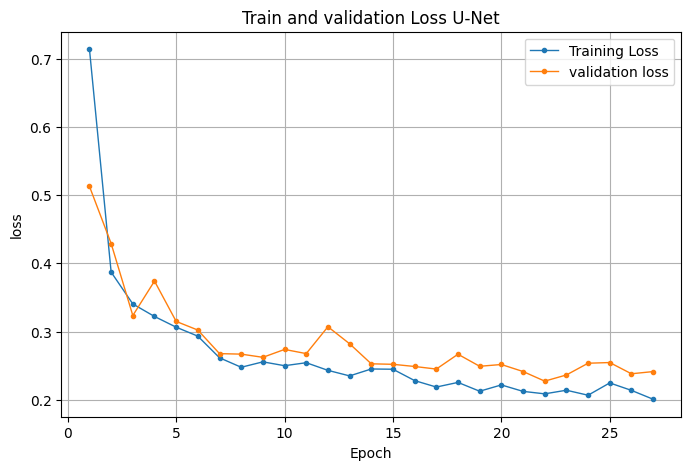

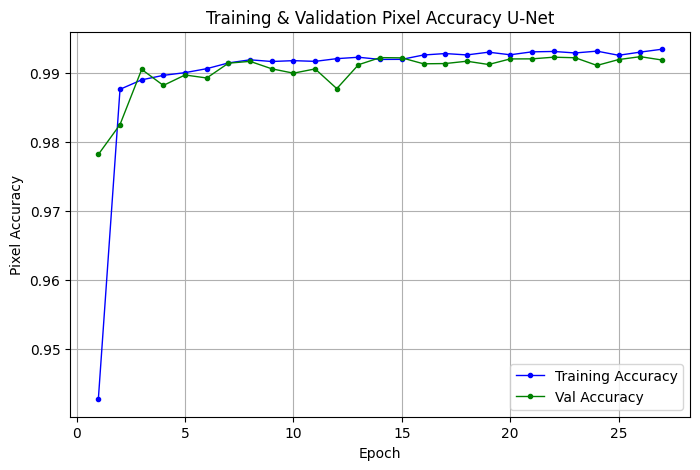

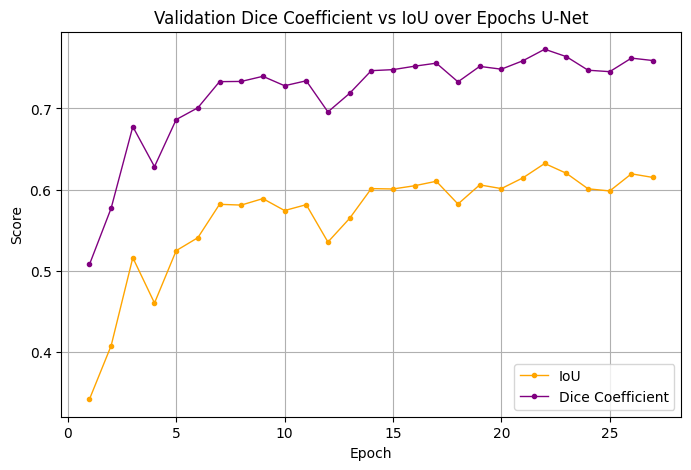

In [18]:
epochs = range(1, len(training_losses)+1)

plt.figure(figsize=(8, 5))

plt.plot(epochs,  training_losses, label="Training Loss",  marker='o', markersize=3, linestyle='-', linewidth=1)
plt.plot(epochs, val_losses, label = "validation loss",   marker='o', markersize=3, linestyle='-', linewidth=1)
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.title("Train and validation Loss U-Net")
plt.legend()
plt.grid(True)
plt.show()



plt.figure(figsize=(8, 5))
plt.plot(epochs, train_accs, label = "Training Accuracy", color = 'blue',  marker='o', markersize=3, linestyle='-', linewidth=1)
plt.plot(epochs, val_accs, label= "Val Accuracy", color= "green",   marker='o', markersize=3, linestyle='-', linewidth=1)
plt.xlabel("Epoch")
plt.ylabel("Pixel Accuracy")
plt.title("Training & Validation Pixel Accuracy U-Net")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(iou_values)+1), iou_values,  label = "IoU", color = "orange", marker='o', markersize=3, linestyle='-', linewidth=1)
plt.plot(range(1, len(dice_values)+1), dice_values, label = "Dice Coefficient", color= "purple", marker='o', markersize=3, linestyle='-', linewidth=1)
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Validation Dice Coefficient vs IoU over Epochs U-Net")
plt.legend()
plt.grid(True)


plt.show()

In [11]:
checkpoint = torch.load("best_model_U-Net.pth", map_location=device)
model.load_state_dict(checkpoint)  # ✅ This loads weights into the model
model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [12]:
warmup_iteration =10
model.eval()

with torch.no_grad():
    for _ in range(warmup_iteration):
        
        for images, _ in test_loader: 
            images  = images.to(device)
            outputs = model(images)
            if device.type  == "mps": 
                torch.tensor(0).to(device)
            break

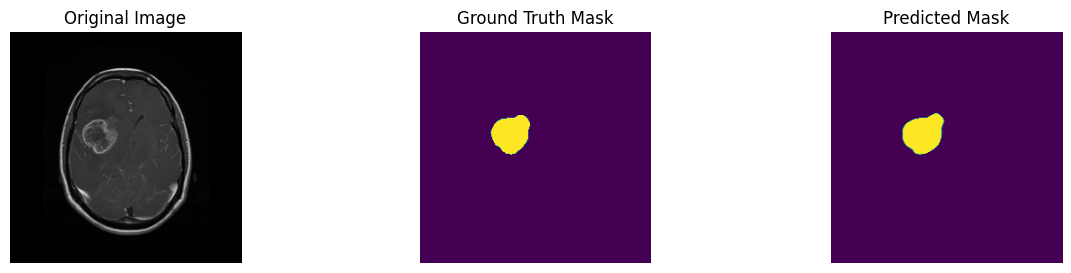

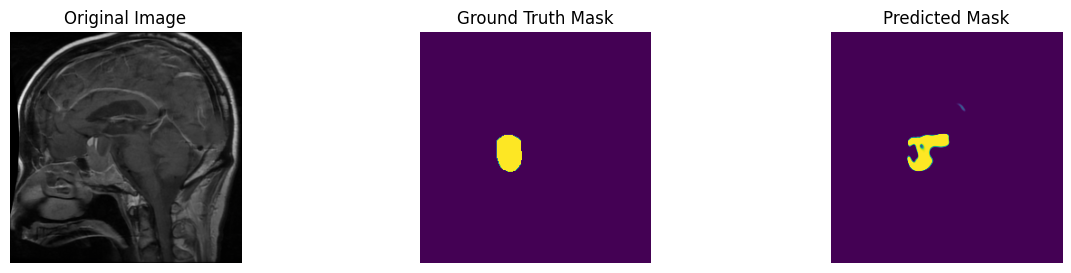

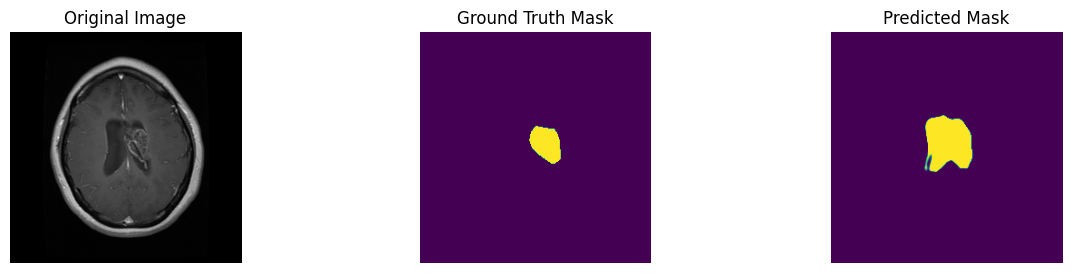

Performance Metrics U-Net:
Average Inference Time per batch (MPS)): 0.5199 seconds
Average Inference Time per Image (MPS) : 0.0017 seconds
Average: Pixel Accuracy for test set: 99.37
Average: Precision for test set: 76.41
Average: Recall for test set: 80.83
Average: F1-score for test set: 76.31
Average: IoU for test set: 67.12
Average: Dice for test set: 76.31


In [22]:

iou_scores = []
dice_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
pixel_acc_scores = []
inference_times = []


with torch.no_grad():
    model.eval()
    for batch_idx, (images, masks) in enumerate (test_loader): 
        
        images = images.to(device)
        masks  = masks.to(device)
        start_time = time.time()
            
        predications = model(images)
        if device.type == "mps":
            torch.tensor(0).to(device)
        
        end_time = time.time()
        inference_times.append(end_time - start_time)
        predications = torch.sigmoid(predications)
        
        for i in range(len(images)):
            
            pixel_acc, precision, recall, f1_score, iou, dice = calculate_metrics(predications[i], masks[i])
            iou_scores.append(iou)
            dice_scores.append(dice)
            precision_scores.append(precision)  
            recall_scores.append(recall)
            f1_scores.append(f1_score)
            pixel_acc_scores.append(pixel_acc)
        
        
            if batch_idx < 3 and i == 0:
                #* visualization of the first three images
                visualization(images[i], masks[i], predications[i])


#*calculating the average of the iou 

average_inference_time = sum(inference_times) / len(inference_times)
average_inference_time_per_image = average_inference_time / len(test_loader.dataset)
average_pixel_acc = sum(pixel_acc_scores) / len(pixel_acc_scores)
average_precision = sum(precision_scores) / len(precision_scores)
average_recall = sum(recall_scores) / len(recall_scores)
average_f1 = sum(f1_scores) / len(f1_scores)
average_iou = sum(iou_scores)/len(iou_scores)
average_dice = sum(dice_scores) / len(dice_scores)


print(f"Performance Metrics U-Net:")
print(f"Average Inference Time per batch (MPS)): {average_inference_time:.4f} seconds")
print(f"Average Inference Time per Image (MPS) : {average_inference_time_per_image:.4f} seconds")
print(f"Average: Pixel Accuracy for test set: {average_pixel_acc * 100:.2f}")
print(f"Average: Precision for test set: {average_precision * 100:.2f}")
print(f"Average: Recall for test set: {average_recall * 100:.2f}")
print(f"Average: F1-score for test set: {average_f1 * 100:.2f}")
print(f"Average: IoU for test set: {average_iou * 100:.2f}")
print(f"Average: Dice for test set: {average_dice * 100:.2f}")

